# Traits models initial run

A first pass fitting a few different sklearn classifiers to the T2D and Lipids datasets. Though some initial preprocessing is conducted on the data no feature selection is performed at this stage. It should be noted that this notebook is meant to show an exploratory look into out of the box model performance. It should be noted that as there are currently more features than samples in the datasets (2750 features vs ~2100 samples), there aren't enough degrees of freedom to optimally fit an interpretable linear model.

In [18]:
import pandas as pd
import numpy as np
import sys
import os
import s3fs
import boto
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
import warnings
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import sklearn 
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from auth import access_key, secret_key
from Evaluator import Evaluator
import itertools

### Data Preprocessing

In [23]:
# Alter with lipids/t2d/other if needed
options = ["t2d", "lipids"]
trait = options[0]

train_filepath = "S3://voightlab-data/{}/{}_training_ML_table.txt".format(trait, trait)
test_filepath = "S3://voightlab-data/{}/{}_testing_ML_table.txt".format(trait, trait)

# Used to name the output files
out_train = "voightlab-data/{}/{}_train.csv".format(trait, trait)
out_test = "voightlab-data/{}/{}_test.csv".format(trait, trait)

In [24]:
train_df = pd.read_table(train_filepath)
test_df = pd.read_table(test_filepath)
train_df.tail()

,snp,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
2116,Chr1_Group_1072,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,65
2117,Chr2_Group_372,control,1,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,5
2118,Chr17_Group_188,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
2119,Chr22_Group_200,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,5
2120,Chr6_Group_23,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31


In [25]:
# Read in data and compare class balances
def show_counts(df, pos_col, neg_col):
    positives = df['type'].value_counts()[pos_col]
    controls = df['type'].value_counts()[neg_col]
    total = len(df)
    print ("Total samples: {} \nPositives: {} \nControls: {}".format(total, positives, controls))

In [26]:
# Read in training data and compare class balances
show_counts(train_df, 'index', 'control')

Total samples: 2121 
Positives: 303 
Controls: 1818


In [27]:
# Read in testing data and compare class balances
show_counts(test_df, 'index', 'control')

Total samples: 1064 
Positives: 152 
Controls: 912


In [28]:
# Change labels to 0 or 1 for control or positive
train_df['type'] = train_df['type'].apply(lambda x: 0 if x == 'control' else 1)
test_df['type'] = test_df['type'].apply(lambda x: 0 if x == 'control' else 1)

# Add sample weights based on prevalence of class
train_df['weight'] = train_df['type'].apply(lambda x: 1.5 if x == 1 else 1)

In [29]:
train_df.head()

,snp,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,weight
0,Chr12_Group_459,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,1.5
1,Chr6_Group_395,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1.5
2,Chr5_Group_351,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.5
3,Chr16_Group_19,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,36,1.5
4,Chr5_Group_55,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1.5


In [30]:
# Drop the snp feature so that only numerical data remains
train_df = train_df.drop(['snp'], axis=1)
test_df = test_df.drop(['snp'], axis=1)

In [31]:
# Verify value counts are the same to check conversion was performed correctly
show_counts(train_df, 1, 0)

Total samples: 2121 
Positives: 303 
Controls: 1818


In [32]:
show_counts(test_df, 1, 0)

Total samples: 1064 
Positives: 152 
Controls: 912


In [33]:
# For storage once we have done the feature selection
def write_to_S3(df, filename):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
    with fs.open(filename, 'wb') as f:
        f.write(bytes_to_write)

In [34]:
# Write out data to file so we don't have to repeat preprocessing 
# every time we train a model from a different file
write_to_S3(train_df, out_train)
write_to_S3(test_df, out_test)

In [35]:
# Shuffle dataframe
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [36]:
# Create training and test sets for model
X_train = train_df.drop(['type', 'weight'], axis=1)
y_train = train_df.loc[:, 'type']

X_test = test_df.drop(['type'], axis=1)
y_test = test_df.loc[:, 'type']

In [37]:
# If we want to add sample weights
sample_weight = train_df['weight']

In [38]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

### Logistic Regression 

Sklearn's logistic regression model, with ten fold cross validation. Using the following parameters:
* cv = 10
* penalty = L1 (Same as lasso regression)
* class_weight = balanced (Sets regularization term C to 1/(class frequency) for each sample. Useful for imbalanced datasets. 

In [39]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000)
log_model.fit(X_train, y_train, sample_weight=sample_weight)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [40]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.25627240143369173
 Recall: 0.9438943894389439
 Accuracy: 0.6006600660066007


In [41]:
print("Test Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_test, y_test, threshold=0.5)

Test Dataset Logistic Model Performance:
 Precision: 0.18617021276595744
 Recall: 0.6907894736842105
 Accuracy: 0.5244360902255639


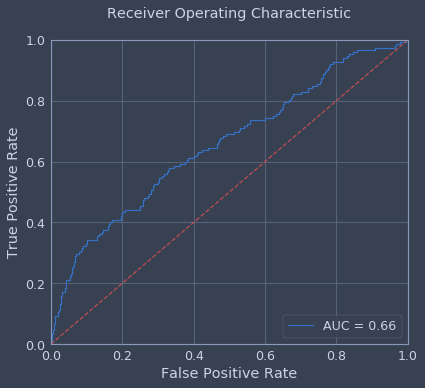

In [42]:
ev.plot_roc_curve(log_model, X_test, y_test)

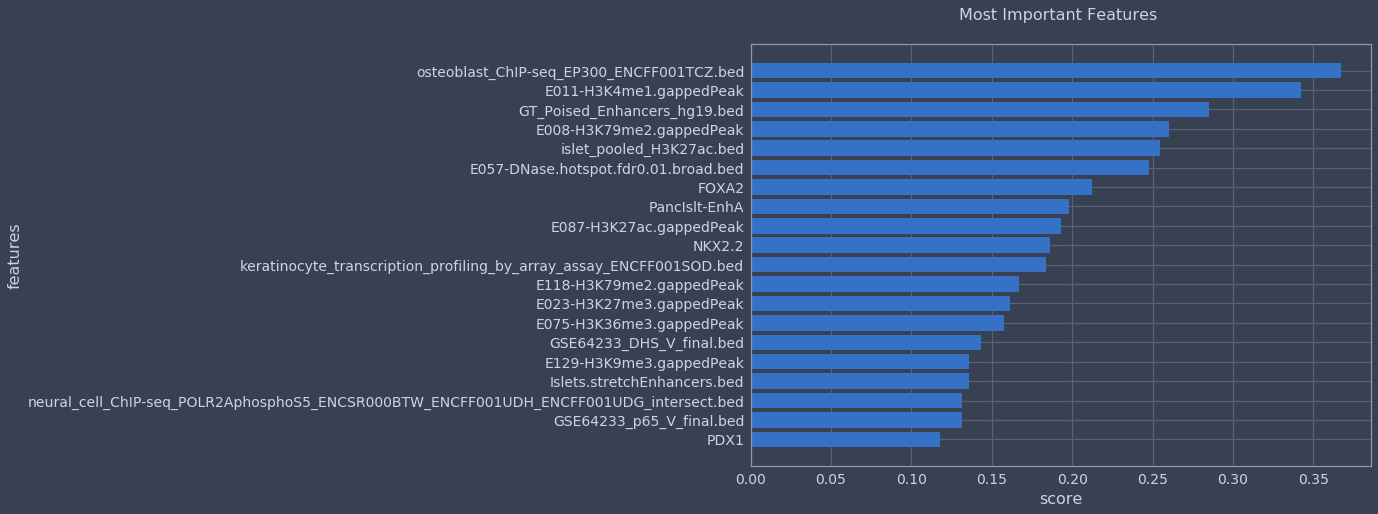

In [43]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, False)

# Random Forest

In [44]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# Parameter grid for grid search
rf_params = {'n_estimators': [100, 500, 1000, 2000],
			 'max_depth': [30, 100, 200]}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [45]:
# Grid search to iteratively search parameter space
rf_grid = GridSearchCV(rf_model, param_grid=rf_params, cv=cv, scoring=scoring, refit='recall')
rf_grid.fit(X_train, y_train, sample_weight=sample_weight)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'max_depth': 100, 'n_estimators': 100} with a score of 0.00
Grid search's score on new test data was 0.0


In [46]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=False)

Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [47]:
ev.summarize_performance(rf_grid.best_estimator_, X_test, y_test, proba=False)

Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.8571428571428571


In [48]:
top_n_features = 20

forest = rf_grid.best_estimator_
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_n_features):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed (0.004608)
2. feature MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed (0.003527)
3. feature GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed (0.003110)
4. feature K562_ChIP-seq_CTCF_ENCFF002CEL.bed (0.003068)
5. feature K562_ChIP-seq_POLR2A_ENCFF002CET.bed (0.002865)
6. feature endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed (0.002765)
7. feature endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed (0.002481)
8. feature keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed (0.002280)
9. feature keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed (0.002245)
10. feature H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed (0.002223)
11. feature mammary_epithelial_cell_ChIP-seq_CTCF_ENCFF002CEB.bed (0.002163)
12. feature HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed (0.002115)
13. feature H1-hESC_ChIP-seq_CTCF_ENCFF002CDS.bed (0.002067)
14. feature H1-hESC_ChIP-seq_H3K4me3_ENCFF001SVC.bed 

### Support Vector Machine 

When used with a linear kernel still allows for evaluation of feature coefficients. Class weight parameter sets regularization parameter C for class i to n_samples / (n_classes * np.bincount(y)) 

In [49]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train, sample_weight=sample_weight)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [51]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_test, y_test, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.20253164556962025
 Recall: 0.21052631578947367
 Accuracy: 0.768796992481203


In [52]:
# Display samples that have been chosen as support vectors
svec_indices = svm_model.support_
svec_df = X_train.iloc[[124, 60, 112, 184, 53], :]
svec_df.tail()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1647,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,36
206,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


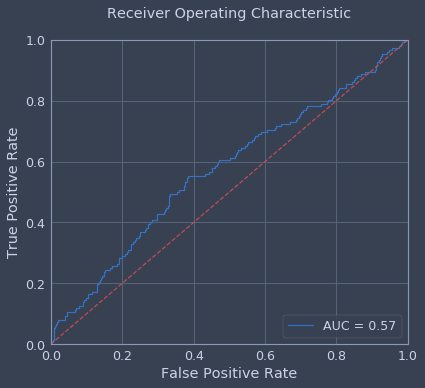

In [53]:
ev.plot_roc_curve(svm_model, X_test, y_test)

In [1]:
# Plot feature importance
coefs = svm_model.coef_
feature_names = X_train.columns
important features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)